# GLM Tutorial with RFEst

This notebook is a replication of the [GLM spike train tutorial](https://github.com/pillowlab/GLMspiketraintutorial) taught by Johnathon Pillow at SfN 2016 and COSYNE 2018. Here, we use spline GLMs from [RFEst](https://github.com/berenslab/RFEst), though quite unnecessary, because the number of RF parameters is small and the amount of data is relatively large, so plain GLMs will perform similar to spline-based ones.

So, the purpose of this notebook is to show how to use different methods from RFest and double check if results from plain and spline-based GLMs are consistent. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rfest import LNP, splineLNP
from rfest import build_design_matrix
from rfest.utils import get_n_samples, split_data, fetch_data, uvec
from rfest.plot import plot1d

## Load data

The dataset used in this tutorial is a small subset from Uzzell & Chichilnisky (2004), open-sourced by Johnathon Pillow on March, 2020. The data can be fetched by `fetch_data` function from RFEst.

In [2]:
data = fetch_data(data=3, datapath='./data/')

Data is already downloaded. To re-download the same file, please set `overwrite=False`.
Loading data (Macaque GRCs from Uzzell & Chichilnisky, 2004)
Done.


In [3]:
stim = data['Stim']
stimtime = data['stimtimes'].flatten()
spiketime = data['SpTimes']

cellnum = 2
tsp = spiketime[0][cellnum].flatten()

dt = stimtime[1] - stimtime[0] # time bin size for stimulus (s)
n_total = len(stim) # number of time bins in stimulus
n_spikes = len(tsp) # number of spikes

print(f'Number of time bins = {n_total} frames')
print(f'Number of spikes = {n_spikes}')
print(f'Size of time bins = {dt:.3f} s')
print(f'Total length of recording = {n_total * dt / 60:.2f} mins')

Number of time bins = 144051 frames
Number of spikes = 49954
Size of time bins = 0.008 s
Total length of recording = 20.02 mins


## Bin spike time into spike train

In [4]:
tbins = np.arange(0, n_total) * dt # bin centers
  # but here in numpy we specified the bin edges
tbins -= np.diff(np.hstack([0, tbins])) / 2
sps, t = np.histogram(tsp, bins=len(tbins), range=(tbins[0], tbins[-1]))

Text(0.5, 0.98, 'Spike count / bin')

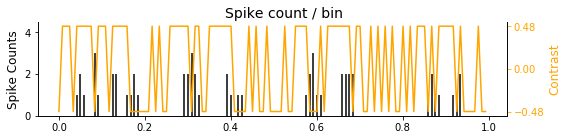

In [5]:
trange = np.arange(120)

fig, ax1 = plt.subplots(figsize=(8,2))

markerline, stemlines, baseline = ax1.stem(trange * dt, sps[trange], linefmt='black',
                    markerfmt='none',label='spikes', use_line_collection=True)
markerline.set_markerfacecolor('none')
plt.setp(baseline,'color', 'none')
ax1.set_ylabel('Spike Counts', fontsize=12, color='black')
ax1.tick_params(axis='y', colors='black')
ax1.spines['top'].set_visible(False)
ax1.set_ylim(0, 4.5)

ax2 = ax1.twinx()
ax2.plot(trange * dt, stim[trange], color='orange', label='Full-field flicker')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Contrast', fontsize=12, color='orange')
ax2.set_yticks([-0.48, 0, 0.48])
ax2.tick_params(axis='y', colors='orange')
ax2.spines['top'].set_visible(False)
# fig.legend(loc="upper right")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Spike count / bin', fontsize=14)


## Split data into Training, Dev and Test set

In [6]:
dims = [25, ]
n_subset = get_n_samples(20, dt)
Xdsgn = build_design_matrix(stim[:, np.newaxis], dims[0])[:n_subset]
y = sps[:n_subset]

(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(Xdsgn, y, dt, frac_train=0.5, frac_dev=0.25)

SUMMARY
               N    Minutes   Fraction
Total     143874       20.0        1.0
Train      71937       10.0        0.5
Dev        35969        5.0       0.25
Test       35968        5.0       0.25


## Shared hyperparameters

In [7]:
df = [10,] # number of basis
beta = 0.01 # l1 reguarlization weight
verbose = 300 # when set to 0, there will be no verbose loggin.
tolerance = 10 # when set to 0, there will be no early stop.
num_epochs = 5
num_iters = 600

## M0: Vanilla Linear-Nonlinear Poisson model

In [8]:
m0 = LNP(X_train, y_train, dims, dt=dt, nonlinearity='exponential')
m0.fit(extra={'X':X_dev, 'y': y_dev}, num_epochs=num_epochs, num_iters=num_iters, 
        metric='corrcoef', beta=beta, verbose=verbose, tolerance=tolerance)

/Users/ziweih/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)

===Epoch 0===
    0	     0.804	  -549.225	  -280.568	     0.370	     0.384
  300	     4.095	-86905.822	-41073.362	     0.665	     0.602
Stop: reached 600 steps.


===Epoch 1===
    0	     9.790	-87258.287	-41415.408	     0.690	     0.626
  300	    13.157	-87269.187	-41462.425	     0.688	     0.626
Stop at 301 steps: cost (train) has been changing less than 1e-5 for 10 steps.


===Epoch 2===
    0	    13.191	-87251.729	-41443.007	     0.691	     0.626
  300	    16.510	-87269.187	-41462.425	     0.688	     0.626
Stop at 301 steps: cost (train) has been changing less than 1e-5 for 10 steps.


===Epoch 3===
    0	    16.542	-87250.824	-41464.537	     0.685	     0.625
  300	    19.814	-87269.187	-41462.425	     0.688	     0.626
Stop at 301 steps: cost (train) has been changing less than 1e-5 for 10 steps.


===Epoch 4===
    0	    19.847	-87250.819	-41464.538	     0.685	     0.625
  300	    23.126	-87269.187	-41462.425	  

## M1: LNP with spline

In [9]:
m1 = splineLNP(X_train, y_train, dims, df, dt=dt, nonlinearity='exponential')
m1.fit(extra={'X':X_dev, 'y': y_dev}, num_epochs=num_epochs, num_iters=num_iters, 
        metric='corrcoef', beta=beta, verbose=verbose, tolerance=tolerance)

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)

===Epoch 0===
    0	     0.460	   -14.605	    -1.708	     0.356	     0.343
  300	     3.196	-82745.169	-40512.058	     0.595	     0.590
Stop: reached 600 steps.


===Epoch 1===
    0	     8.154	-84198.741	-41336.383	     0.614	     0.621
  300	    10.932	-84436.016	-41836.202	     0.600	     0.633
Stop at 301 steps: cost (train) has been changing less than 1e-5 for 10 steps.


===Epoch 2===
    0	    10.960	-84433.614	-41824.969	     0.600	     0.633
  300	    13.839	-84436.016	-41836.199	     0.600	     0.633
Stop at 301 steps: cost (train) has been changing less than 1e-5 for 10 steps.


===Epoch 3===
    0	    13.867	-84432.600	-41828.150	     0.600	     0.633
  300	    16.631	-84436.016	-41836.199	     0.600	     0.633
Stop at 301 steps: cost (train) has been changing less than 1e-5 for 10 steps.


===Epoch 4===
    0	    16.659	-84431.740	-41830.604	     0.599	     0.632
  300	    19.445	-84436.016	-41836.199	  

## M2: LNP with spline and response history filter

In [10]:
m2 = splineLNP(X_train, y_train, dims, df, dt=dt, nonlinearity='exponential')
m2.initialize_history_filter(dims[0], df[0])
m2.fit(extra={'X':X_dev, 'y': y_dev}, num_epochs=num_epochs, num_iters=num_iters, 
        metric='corrcoef', beta=beta, verbose=verbose, 
        fit_history_filter=True, tolerance=tolerance)

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)

===Epoch 0===
    0	     0.491	-11327.121	 -5570.006	     0.293	     0.299
  300	     4.233	-79541.033	-39024.826	     0.471	     0.482
Stop: reached 600 steps.


===Epoch 1===
    0	     9.995	-83708.358	-40948.857	     0.586	     0.584
  300	    13.707	-86282.106	-42329.098	     0.664	     0.663
Stop: reached 600 steps.


===Epoch 2===
    0	    19.479	-86518.035	-42459.175	     0.660	     0.665
  300	    23.177	-86533.221	-42442.134	     0.657	     0.664
Stop at 301 steps: cost (train) has been changing less than 1e-5 for 10 steps.


===Epoch 3===
    0	    23.212	-86516.797	-42329.727	     0.656	     0.664
  300	    26.919	-86533.221	-42442.134	     0.657	     0.664
Stop at 301 steps: cost (train) has been changing less than 1e-5 for 10 steps.


===Epoch 4===
    0	    26.955	-86516.696	-42329.134	     0.656	     0.664
  300	    30.653	-86533.221	-42442.134	     0.657	     0.664
Stop at 301 steps: cost (train) ha

## M3: LNP with spline, response history filter and parametric nonlinearity

In [11]:
m3 = splineLNP(X_train, y_train, dims, df=df, dt=dt, nonlinearity='spline')
m3.initialize_history_filter(dims[0], df[0])
m3.initialize_parametric_nonlinearity(init_to='exponential', params_dict={'df': 11})
m3.fit(extra={'X':X_dev, 'y': y_dev}, num_iters=3000,
        metric='corrcoef', beta=beta, verbose=verbose, tolerance=tolerance,
        fit_history_filter=True, fit_nonlinearity=True)

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     1.419	-12272.063	 -6032.687	     0.295	     0.301
  300	    11.482	-79698.349	-39150.930	     0.492	     0.502
  600	    23.864	-83740.888	-40985.286	     0.600	     0.602
  900	    36.151	-85547.085	-41929.237	     0.651	     0.653
 1200	    48.287	-86359.371	-42388.773	     0.673	     0.682
 1500	    60.367	-86719.452	-42580.584	     0.682	     0.697
 1800	    72.991	-86896.262	-42656.816	     0.685	     0.706
 2100	    85.065	-87001.410	-42692.656	     0.687	     0.712
 2400	    98.702	-87080.315	-42721.510	     0.690	     0.717
 2700	   111.091	-87157.296	-42763.242	     0.695	     0.722
Stop: reached 3000 steps.

Total time elapsed: 123.204 s.


## Plot receptive fields

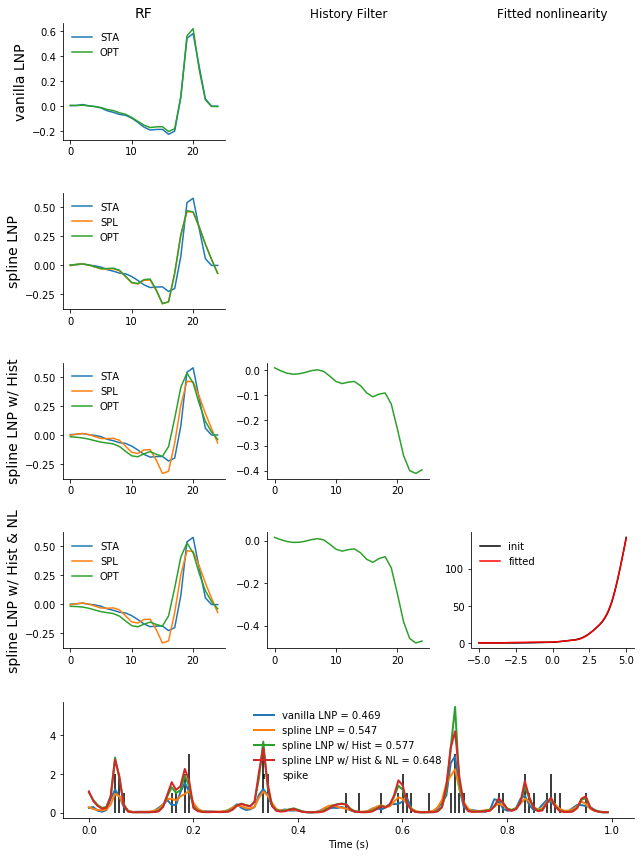

In [12]:
model_names = ['vanilla LNP', 'spline LNP', 'spline LNP w/ Hist', 'spline LNP w/ Hist & NL']
plot1d([m0, m1, m2, m3], X_test, y_test, dt=dt, len_time=1,
       model_names = model_names)